In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import model_utils
import plot_utils

from custom_datasets import PascalDataset, PascalBboxDataset, ConcatDS
from custom_transforms import *
from custom_layers import Flatten

In [2]:
DATA_DIR = Path('../data/pascal')
JPEG_DIR = DATA_DIR/'VOCdevkit/VOC2007/JPEGImages'
CSVS_DIR = DATA_DIR/'csvs'
data = json.load((DATA_DIR/'pascal_train2007.json').open())

DATA_IMAGES, DATA_TYPE, DATA_ANNOTATIONS, DATA_CATEGORIES = data['images'], data['type'], data['annotations'], data['categories']

category_dic = {x['id']:x['name'] for x in DATA_CATEGORIES}
jpeg_dic = {x['id']:x for x in DATA_IMAGES}
annotations_dic = defaultdict(lambda : []) 

for ann in DATA_ANNOTATIONS:
    if ann['ignore']==0:
        annotations_dic[ann['image_id']].append((ann['bbox'],ann['category_id'])) 

# Combined model, classifier + bbox

In [3]:
train_idxs, val_idxs = model_utils.get_trn_val_idxs(len(DATA_IMAGES))

In [4]:
bs = 64
sz = 224
n_epochs = 5
lr = 0.001

classifier_train_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor()
])

classifier_val_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor()
])

bbox_train_tfms = transforms.Compose([
    ResizeImgAndBbox((sz, sz)),
    RandomFlipImgAndBbox(),
    #RandomRotateImgAndBbox(5), 
    ColorJitter(),
    ImgAndBboxToTensor()
])

bbox_val_tfms = transforms.Compose([
    ResizeImgAndBbox((sz, sz)),
    ImgAndBboxToTensor()
])

In [5]:
concat_train_ds = ConcatDS(PascalBboxDataset(CSVS_DIR/'largest_item_bbox.csv', JPEG_DIR, bbox_train_tfms), 
                           PascalDataset(CSVS_DIR/'largest_item_classifier.csv', JPEG_DIR, classifier_train_tfms))

concat_train_dl = torch.utils.data.DataLoader(concat_train_ds, 
                                              bs, 
                                              sampler=SubsetRandomSampler(train_idxs))


concat_val_ds = ConcatDS(PascalBboxDataset(CSVS_DIR/'largest_item_bbox.csv', JPEG_DIR, bbox_val_tfms), 
                           PascalDataset(CSVS_DIR/'largest_item_classifier.csv', JPEG_DIR, classifier_val_tfms))

concat_val_dl = torch.utils.data.DataLoader(concat_val_ds, 
                                            bs, 
                                            sampler=SubsetRandomSampler(val_idxs))

In [6]:
custom_head = nn.Sequential(
        Flatten(),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512*7*7, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),
        nn.Linear(256, 4+20)
    )

model = model_utils.get_resnet34_model_with_custom_head(custom_head)

In [7]:
model.load_state_dict(torch.load(DATA_DIR/'my-models/combined_model_val_77.5.ckpt', map_location='cpu'))

In [ ]:
model.train()
n_epochs = 5
lr = 0.001
logger = model_utils.create_tensorboard_logger('./logs/combined/run_1')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels in concat_train_dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = combined_loss(preds, labels, sz)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        log_info = {
            'Detection overall loss': loss.item(), 
            'Detection l1 loss': model_utils.get_detection_l1_loss(preds[:,:4], labels[0], sz), 
            'Detection cross entropy loss': model_utils.get_detection_cross_entropy_loss(preds[:,4:], labels[1]),
            'Detection accuracy' : model_utils.get_detection_accuracy(preds[:,4:], labels[1])
        }
        
        model_utils.log_scalars_to_tensorboard_logger(logger, log_info, total_steps)                                                    
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(concat_train_dl))

In [ ]:
trn_acc, trn_loss = model_utils.get_concat_model_summary_on_sample_set(model, concat_train_dl, sz)        
val_acc, val_loss = model_utils.get_concat_model_summary_on_sample_set(model, concat_val_dl, sz)
print('Model accuracy, loss on training set:{}%, {}, validation set:{}%, {}'.format(trn_acc, trn_loss, val_acc, val_loss))                      

In [8]:
model.eval()
with torch.no_grad():
    batch, labels = iter(concat_val_dl).next()
    
    batch = batch.to(device)
    labels[0] = labels[0].to(device)
    labels[1] = labels[1].to(device)
    
    preds = model(batch)
    
    pred_bboxes, pred_class_scores = preds[:,:4], preds[:, 4:]
    pred_bboxes = torch.sigmoid(pred_bboxes)*sz
    pred_cat_ids = pred_class_scores.argmax(dim=1)
    
    actual_bboxes, actual_cat_ids = labels

In [9]:
#torch.save((batch, pred_bboxes, pred_cat_ids, labels), './Saved Tensors/concat_model_sample_predictions.pt')
batch, pred_bboxes, pred_cat_ids, labels = torch.load('./Saved Tensors/concat_model_sample_predictions.pt')

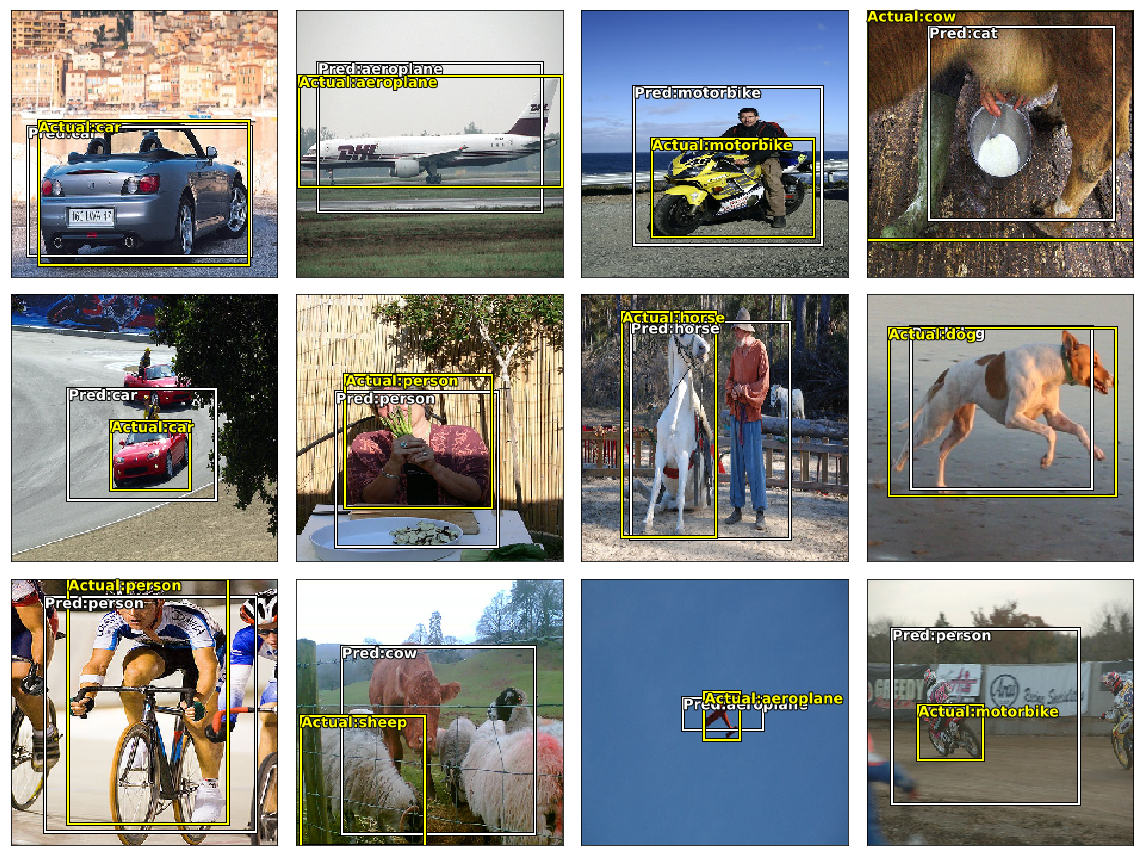

In [13]:
plot_utils.plot_concat_model_predictions_on_sample_batch(batch, (pred_bboxes, pred_cat_ids), labels, 
                                                         concat_train_ds.get_category_label, plot_from=24)

In [8]:
def plot_results_on_single_img(im_path):
    im = Image.open(im_path)
    
    sz = 224
    test_tfms = transforms.Compose([
        transforms.Resize((sz, sz)),
        transforms.ToTensor()
    ])
    test_im_tensor = test_tfms(im)[None]
    
    pred_bbox, pred_cat_id = model_utils.test_on_single_image(test_im_tensor, model, sz)
    get_label_fn = concat_val_ds.get_category_label
    plot_utils.plot_model_result_on_test_image(pred_bbox, pred_cat_id, get_label_fn, im_path)

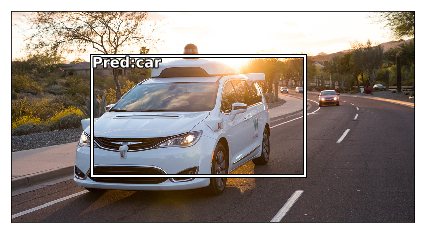

In [9]:
im_path = 'test_images/waymo_banner.jpg'
plot_results_on_single_img(im_path)

In [8]:
concat_val_dl.dataset.classifier_ds.id_to_cat

{0: 'car',
 1: 'horse',
 2: 'person',
 3: 'aeroplane',
 4: 'train',
 5: 'dog',
 6: 'chair',
 7: 'boat',
 8: 'bird',
 9: 'pottedplant',
 10: 'cat',
 11: 'sofa',
 12: 'motorbike',
 13: 'tvmonitor',
 14: 'bus',
 15: 'sheep',
 16: 'diningtable',
 17: 'bottle',
 18: 'cow',
 19: 'bicycle'}